In [7]:
import pandas as pd
import json
import glob
import tqdm
import seaborn as sns
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore")

from model_drift import settings



In [8]:
def converter(value):
    if isinstance(value, list):
        d = {str(i):vv for i, vv in enumerate(value)}
        d['all'] = value
        return d
    return value

In [10]:
df = []

jsonl_dir = str(settings.DATA_DIR.joinpath("red_head_h0x1hbjf"))
jsonl_files = glob.glob(f"{jsonl_dir}/*.jsonl")

for fn in tqdm.tqdm_notebook(jsonl_files):
    with open(fn, 'r') as f:
        for line in tqdm.tqdm_notebook(f.readlines()):
            df.append({k: converter(v) for k, v in json.loads(line).items()})
print(len(df))
df = pd.json_normalize(df)
print(len(df))
df.head()

D:\Code\MLOpsDay2\MedImaging-ModelDriftMonitoring\.venv\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/4 [00:00<?, ?it/s]

D:\Code\MLOpsDay2\MedImaging-ModelDriftMonitoring\.venv\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/26387 [00:00<?, ?it/s]

  0%|          | 0/26392 [00:00<?, ?it/s]

  0%|          | 0/26371 [00:00<?, ?it/s]

  0%|          | 0/26381 [00:00<?, ?it/s]

105531
105531


,index,error,mu.0,mu.1,mu.2,mu.3,mu.4,mu.5,mu.6,mu.7,...,logvar.119,logvar.120,logvar.121,logvar.122,logvar.123,logvar.124,logvar.125,logvar.126,logvar.127,logvar.all
0,20536686640136348236148679891455886468_k6ga29.png,0.017571,-0.015945,-0.013659,0.054871,-0.044911,0.013308,-0.059031,-0.007672,0.103230,...,-0.018902,-1.164789,0.008582,0.021520,0.017799,-0.019862,-0.004990,0.004133,-0.025369,"[-0.015835635364055634, -0.008164092898368835,..."
1,113855343774216031107737439268243531979_3k951n...,0.075379,-0.063785,-0.228841,0.063025,0.148872,0.235560,-0.026813,-0.069000,0.387944,...,-0.040039,-0.991471,-0.095479,-0.111494,-0.040676,-0.005235,0.010469,-0.038714,-0.021370,"[-0.07500659674406052, -0.04446641355752945, 0..."
2,313723174271082992847610802266403640553-4_hhi4...,0.022395,0.015599,-0.055860,0.037510,-0.034584,0.016954,-0.040431,-0.001893,0.057926,...,-0.011489,-1.242234,-0.040924,0.019805,0.023912,-0.025186,-0.025734,0.003396,-0.019047,"[0.009179182350635529, 0.03407943248748779, -0..."
3,105529804483623054726294337265160703666_6zn76a...,0.014906,0.013436,0.003932,0.012120,-0.023085,-0.016371,-0.030419,0.010042,0.030318,...,-0.012832,-1.227103,-0.034643,-0.011888,0.029016,-0.015547,0.001015,-0.007563,0.007666,"[0.019098788499832153, -0.0003490149974822998,..."
4,102185472428957491598043403159908631419_zb8kco...,0.090683,-0.085357,-0.318316,0.006658,0.150164,0.198497,-0.078318,-0.067534,0.380174,...,-0.041675,-0.965242,-0.069933,-0.127978,-0.058771,-0.005823,0.061378,-0.065650,-0.046964,"[-0.07593396306037903, 0.0031846128404140472, ..."


In [11]:
print(len(df))

105531


In [12]:
pc_df = pd.read_csv(settings.PADCHEST_FILENAME, low_memory=False)

In [13]:
pc_df_vae = pc_df.merge(df, left_on="ImageID", right_on="index", how='inner')

In [14]:
## Include this?

pc_df_vae["Projection"].value_counts()
pc_df_vae["View"] = pc_df_vae["Projection"]
pc_df_vae.loc[pc_df_vae["View"].isin(["PA", "AP_horizontal", "AP"]), "View"] = 'Frontal'
pc_df_vae['View'].value_counts()

Frontal    72048
L          33115
COSTAL       367
UNK            1
Name: View, dtype: int64

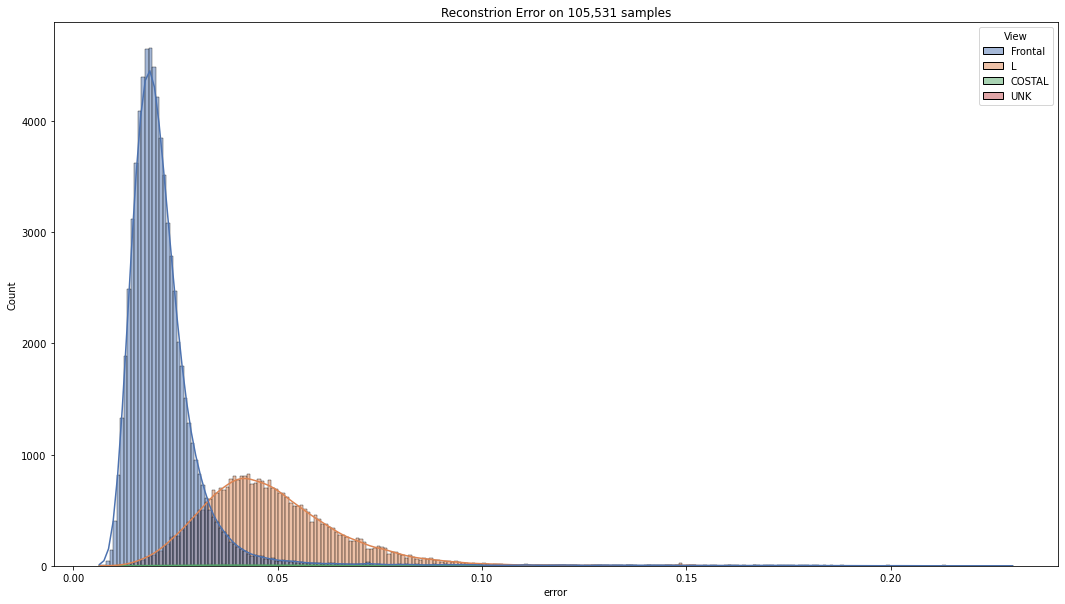

In [32]:
sns.set_palette('deep')
figsize = [18, 10]
fig, ax = plt.subplots(figsize=figsize)
hue = "View"

_ = sns.histplot(data=pc_df_vae, x="error", hue=hue, ax=ax, kde=True)
_ = ax.set(title=f"Reconstrion Error on {len(pc_df_vae):,d} samples")

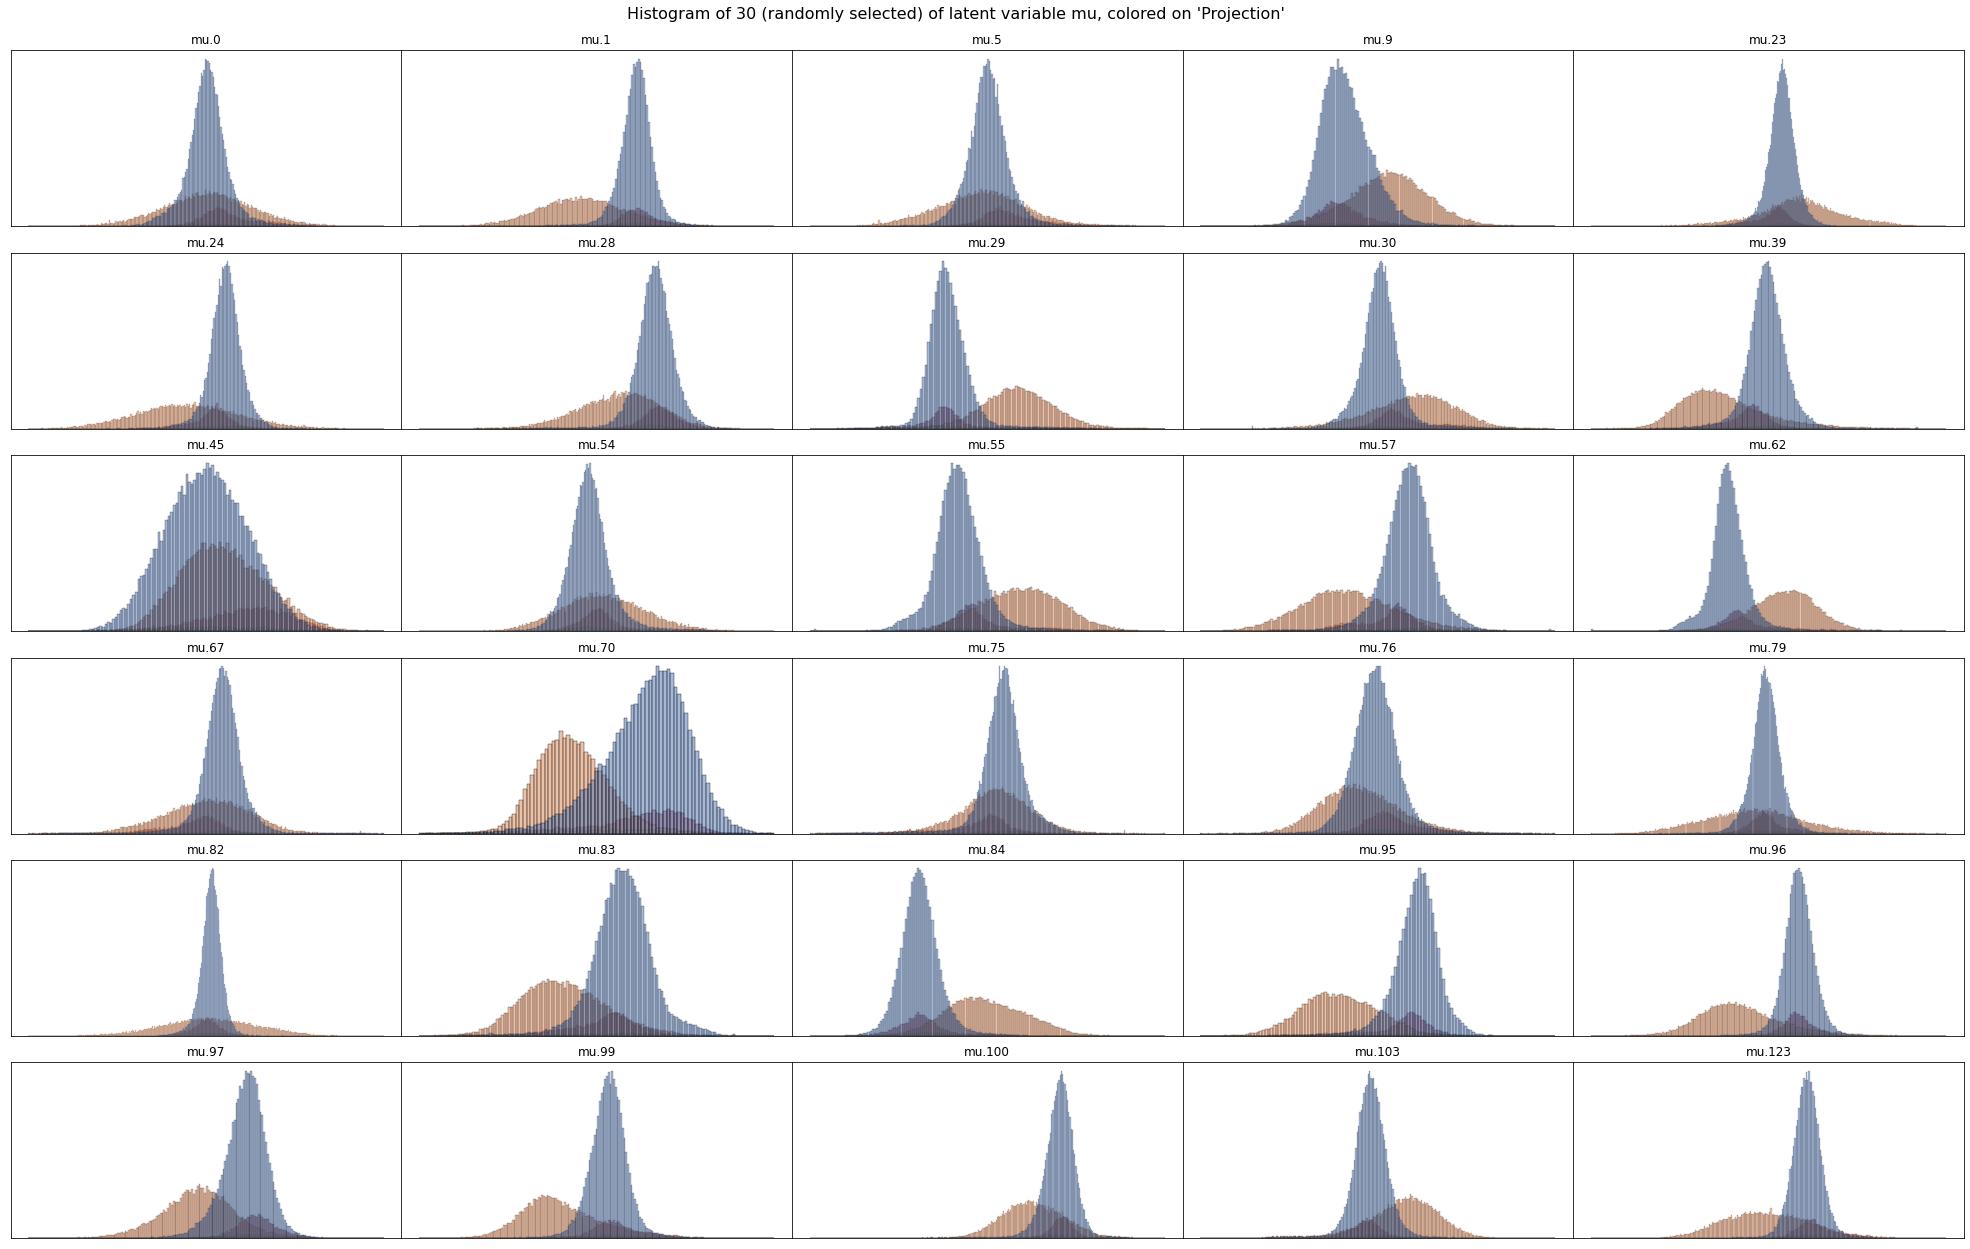

In [16]:
import random
grid_size = (6, 5)
figsize = [35, 20]
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize, gridspec_kw={'wspace':0, 'hspace':.15})
fig.set_facecolor('w')
axes = axes.flatten()
i_vals = list(range(128))

random.shuffle(i_vals)

i_vals = sorted(i_vals[:len(axes)])
col = "mu"
hue = "Projection"

s = (f"Histogram of {len(i_vals)} (randomly selected) of latent variable {col}, colored on '{hue}'")
for i, i_val in enumerate(i_vals):
    xcol = f"mu.{i_val}"
    _ = sns.histplot(data=pc_df_vae, x=xcol, hue=hue,  ax=axes[i])
    axes[i].set_title(xcol)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set(ylabel=None, xlabel=None)
    if 1:
        axes[i].get_legend().remove()
        continue
    # axes[i].legend(bbox_to_anchor=(-0.01, -0.2), loc='upper right', ncol=5)

fig.suptitle(s, fontsize=16)
fig.subplots_adjust(top=.95)

In [47]:
from model_drift.stats import calc_p_real


ref = pc_df_vae.query("View == 'Frontal'")
target = pc_df_vae.query("View != 'Frontal'")
pvals = []
for i_val in range(128):
    xcol = f"mu.{i_val}"
    samp1 = ref[xcol].values
    samp2 = target[xcol].values
    ks, p = ks_2samp(samp1, samp2)
    if ks>0.5:
        p = 1-p
    pvals.append(ks)
    # axes[i].legend(bbox_to_anchor=(-0.01, -0.2), loc='upper right', ncol=5)

<BarContainer object of 128 artists>

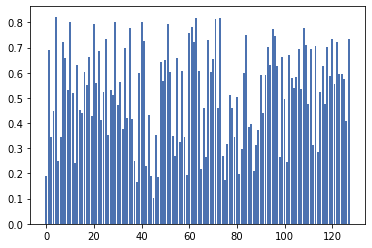

In [48]:
plt.bar(list(range(128)), pvals)

In [30]:
len(ref), len(target)

(72048, 33483)

In [35]:
calc_p_real(ref["error"].values, target["error"].values)

0.0

In [40]:
from scipy.stats import ks_2samp
ks_2samp(ref["error"].values, target["error"].values)

KstestResult(statistic=0.7812000458713196, pvalue=0.0)

In [36]:
ref["error"].values[:10]

array([0.01757107, 0.01544717, 0.03388681, 0.02718422, 0.0182364 ,
       0.02239492, 0.01763722, 0.02342774, 0.02066833, 0.01490599])

In [37]:
target["error"].values[:10]

array([0.03697437, 0.07537937, 0.0655725 , 0.0382699 , 0.09068341,
       0.04687092, 0.06717499, 0.04179861, 0.06267914, 0.10051547])

In [77]:
import numpy as np
from numpy.random import randn
from numpy.random import lognormal

data_norm1 = randn(100000)
data_lognormal = lognormal(3, 1, 100000)
data_norm2 = randn(100000)

print("norm1 vs lognormal:", ks_2samp(data_norm1, data_lognormal))
print("norm1 vs norm2:", ks_2samp(data_norm1, data_norm2))
print("norm1 vs norm1:", ks_2samp(data_norm1, data_norm1))

print("norm1 vs norm2+lognormal:", ks_2samp(data_norm1, np.hstack([data_norm2, data_lognormal])))

norm1 vs lognormal: KstestResult(statistic=0.97516, pvalue=0.0)
norm1 vs norm2: KstestResult(statistic=0.004229999999999956, pvalue=0.33167604557895036)
norm1 vs norm1: KstestResult(statistic=0.0, pvalue=1.0)
norm1 vs norm2+lognormal: KstestResult(statistic=0.48748499999999995, pvalue=0.0)


In [ ]:
from scipy import stats


print("norm1 vs lognormal:", stats.ttest_ind(data_norm1, data_lognormal, False))
print("norm1 vs norm2:", stats.ttest_ind(data_norm1, data_norm2, False))
print("norm1 vs norm1:", stats.ttest_ind(data_norm1, data_norm1, False))

print("norm1 vs norm2+lognormal:", ks_2samp(data_norm1, np.hstack([data_norm2, data_lognormal])))

In [ ]:
from scipy.stats import ks_2samp
ks_2samp(ref["error"].values, target["error"].values)

KstestResult(statistic=0.7812000458713196, pvalue=0.0)